***
<p style="text-align:left;">Deep Learning
<span style="float:right;">Thursday, 30. April 2020</span></p>

<p style="text-align:left;">Prof. S. Harmeling
<span style="float:right;">DUE 23:55 Wednesday, 06. May 2020</span></p>

---
<p style="text-align:center;"><b>Exercise set #2</b></p>

# Softmax classifier

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized loss function for the Softmax classifier
- implement the fully-vectorized expression for its analytic gradient
- check your implementation with numerical gradient
- use a validation set to tune the learning rate and regularization strength
- optimize the loss function with SGD
- visualize the final learned weights

<b>This exercise is copied from Fei-Fei Li course cs231n in Stanford, http://cs231n.stanford.edu/2018/ . Used with permission. </b>


In [1]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [24]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.300914
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Softmax gives us a probability for each class label. As we have 10 classes, we would expect each class to have a probability of 0.1.

In [30]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.466278 analytic: 0.466278, relative error: 3.091405e-09
numerical: -0.994086 analytic: -0.994086, relative error: 7.503316e-09
numerical: 1.269418 analytic: 1.269418, relative error: 2.196348e-08
numerical: -0.177177 analytic: -0.177177, relative error: 7.092072e-08
numerical: 1.416172 analytic: 1.416172, relative error: 5.629471e-08
numerical: -1.688952 analytic: -1.688952, relative error: 1.358712e-08
numerical: -4.071462 analytic: -4.071462, relative error: 9.697768e-09
numerical: 0.120887 analytic: 0.120887, relative error: 1.984522e-07
numerical: -0.908474 analytic: -0.908474, relative error: 8.064376e-08
numerical: -2.829328 analytic: -2.829328, relative error: 2.001689e-08
numerical: 3.174499 analytic: 3.174499, relative error: 7.509831e-09
numerical: 0.738120 analytic: 0.738120, relative error: 2.612714e-08
numerical: -3.305455 analytic: -3.305455, relative error: 2.041403e-08
numerical: -0.969229 analytic: -0.969229, relative error: 5.559228e-08
numerical: 3.63301

In [41]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.300914e+00 computed in 0.191860s
vectorized loss: 2.300914e+00 computed in 0.003777s
Loss difference: 0.000000
Gradient difference: 0.000000


In [47]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
regularization_strengths = [2.5e4, 5e4, 1e3, 5e3, 1e2, 1e5, 1e6, 4e4, 2.5e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
for lr in learning_rates:
    for re in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=re,
                              num_iters=2000, verbose=False)
        
        y_train_pred = softmax.predict(X_train)
        training_acc=np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        validation_acc=np.mean(y_val == y_val_pred)
        
        if best_val < validation_acc :
            best_val=validation_acc
            best_softmax=softmax            
        results[(lr,re)]= training_acc, validation_acc
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 1.000000e+02 train accuracy: 0.142714 val accuracy: 0.146000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.146041 val accuracy: 0.144000
lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.141408 val accuracy: 0.155000
lr 1.000000e-08 reg 2.500000e+04 train accuracy: 0.162653 val accuracy: 0.168000
lr 1.000000e-08 reg 4.000000e+04 train accuracy: 0.165347 val accuracy: 0.180000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.139367 val accuracy: 0.144000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.196388 val accuracy: 0.211000
lr 1.000000e-08 reg 2.500000e+05 train accuracy: 0.268571 val accuracy: 0.285000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.250939 val accuracy: 0.263000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.237449 val accuracy: 0.235000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.242714 val accuracy: 0.255000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.286449 val accuracy: 0.315000
lr 1.000000e-07 reg 2.500000

In [48]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.378000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: For the SVM loss, if the point is out of the range of the margin it wont affect the loss, but that is not true for the softmax loss.

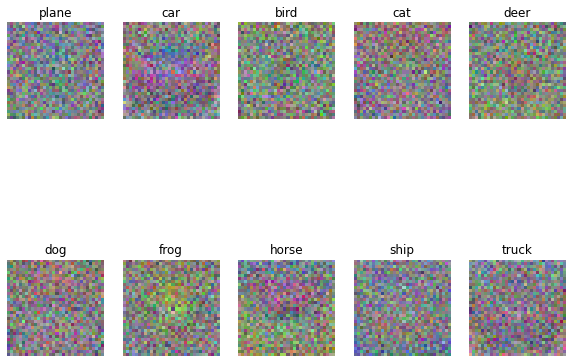

In [49]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])